# Posterior Sampling and Advanced Inference

Beyond point estimates (posterior mean, lfsr), pymash can draw samples from
the posterior distribution. Posterior samples allow you to compute any
summary you like — for example, the probability that two conditions share
an effect of similar magnitude.

This notebook covers:
- Drawing posterior samples during `mash()` fitting
- Post-hoc sampling with `mash_compute_posterior_matrices()`
- Computing pairwise sharing from samples vs. point estimates
- Visualizing sharing matrices

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pymash as mash
from pymash.results import get_pairwise_sharing_from_samples

## Set Up and Fit

Simulate data and set up the model as in the introduction.

In [2]:
sim = mash.simple_sims(nsamp=500, ncond=5, err_sd=1.0, seed=1)
data = mash.mash_set_data(sim["Bhat"], sim["Shat"])
U_c = mash.cov_canonical(data)

## Draw Posterior Samples During Fitting

Pass `posterior_samples=N` to `mash()` to draw N samples from the posterior
for each effect. The result has shape `(J, R, N)`.

In [3]:
result = mash.mash(data, Ulist=U_c, posterior_samples=100, seed=1)
print(f"Posterior samples shape: {result.posterior_samples.shape}")
print(f"  J={result.posterior_samples.shape[0]} effects")
print(f"  R={result.posterior_samples.shape[1]} conditions")
print(f"  M={result.posterior_samples.shape[2]} samples")

Posterior samples shape: (2000, 5, 100)
  J=2000 effects
  R=5 conditions
  M=100 samples


## Post-Hoc Sampling

If you already fitted a model without samples, you can draw them afterwards
using `mash_compute_posterior_matrices()`.

In [4]:
# Fit without samples first
result_nosamp = mash.mash(data, Ulist=U_c)
print(f"Posterior samples: {result_nosamp.posterior_samples}")

# Now draw samples post-hoc
pm = mash.mash_compute_posterior_matrices(
    result_nosamp, data, posterior_samples=100, seed=1
)
print(f"Post-hoc samples shape: {pm.posterior_samples.shape}")

Posterior samples: None
Post-hoc samples shape: (2000, 5, 100)


## Pairwise Sharing from Samples

The sample-based sharing computation averages over posterior uncertainty:
for each pair of conditions, it computes the posterior probability that
the effects are the same sign and within a factor of each other.

Setting `lfsr_thresh=1` includes all effects (not just significant ones).

In [5]:
sharing_samples_all = get_pairwise_sharing_from_samples(
    result, factor=0.5, lfsr_thresh=1
)
print("Sharing from samples (all effects, factor=0.5):")
print(np.array2string(sharing_samples_all, precision=2))

Sharing from samples (all effects, factor=0.5):
[[0.61 0.27 0.27 0.27 0.27]
 [0.27 0.51 0.27 0.27 0.27]
 [0.27 0.27 0.51 0.27 0.27]
 [0.27 0.27 0.27 0.52 0.27]
 [0.27 0.27 0.27 0.27 0.51]]


In [6]:
# Among significant effects only
sharing_samples_sig = get_pairwise_sharing_from_samples(
    result, factor=0.5, lfsr_thresh=0.05
)
print("Sharing from samples (significant effects, factor=0.5):")
print(np.array2string(sharing_samples_sig, precision=2))

Sharing from samples (significant effects, factor=0.5):
[[0.99 0.79 0.82 0.82 0.82]
 [0.79 0.99 0.9  0.87 0.87]
 [0.82 0.9  0.99 0.91 0.9 ]
 [0.82 0.87 0.91 0.99 0.89]
 [0.82 0.87 0.9  0.89 0.99]]


## Compare: Samples vs. Point Estimates

`get_pairwise_sharing()` uses only the posterior mean (a point estimate),
while `get_pairwise_sharing_from_samples()` averages over posterior
uncertainty. The sample-based version is generally more principled.

In [7]:
sharing_point = mash.get_pairwise_sharing(result, factor=0.5)

print("Point-estimate sharing (significant, factor=0.5):")
print(np.array2string(sharing_point, precision=2))
print("\nSample-based sharing (significant, factor=0.5):")
print(np.array2string(sharing_samples_sig, precision=2))

Point-estimate sharing (significant, factor=0.5):
[[1.   0.84 0.87 0.84 0.86]
 [0.84 1.   0.95 0.92 0.91]
 [0.87 0.95 1.   0.97 0.95]
 [0.84 0.92 0.97 1.   0.93]
 [0.86 0.91 0.95 0.93 1.  ]]

Sample-based sharing (significant, factor=0.5):
[[0.99 0.79 0.82 0.82 0.82]
 [0.79 0.99 0.9  0.87 0.87]
 [0.82 0.9  0.99 0.91 0.9 ]
 [0.82 0.87 0.91 0.99 0.89]
 [0.82 0.87 0.9  0.89 0.99]]


## Visualize Sharing Matrices

Heatmaps provide an intuitive view of which conditions share effects.

/var/folders/43/kl9p563s6ld9j5mx5sm7_vz80000gn/T/ipykernel_33338/743007800.py:22: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


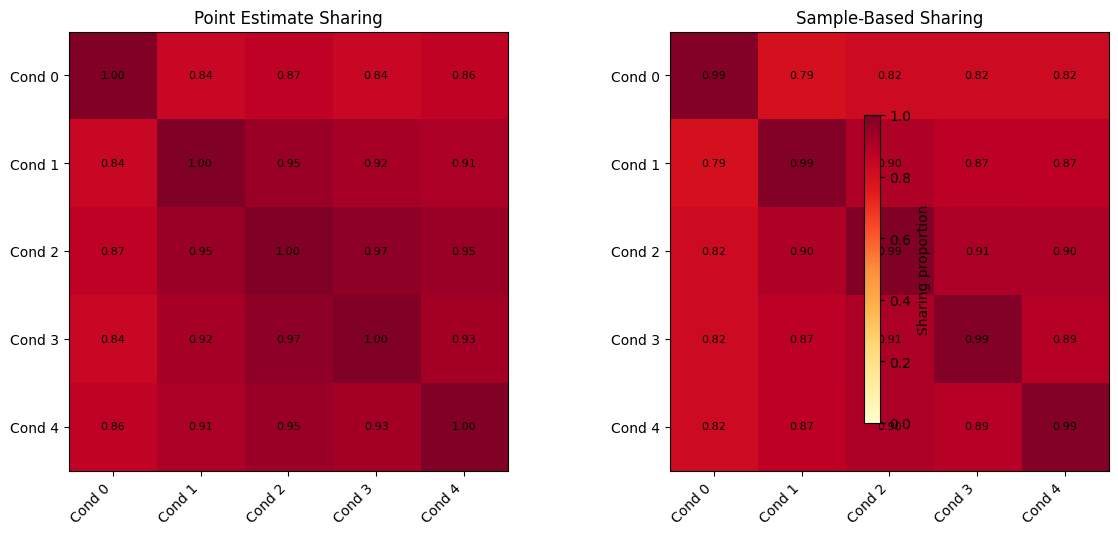

In [8]:
def plot_sharing(mat, title, ax):
    R = mat.shape[0]
    im = ax.imshow(mat, vmin=0, vmax=1, cmap="YlOrRd")
    ax.set_xticks(range(R))
    ax.set_yticks(range(R))
    ax.set_xticklabels([f"Cond {i}" for i in range(R)], rotation=45, ha="right")
    ax.set_yticklabels([f"Cond {i}" for i in range(R)])
    ax.set_title(title)
    # Annotate cells
    for i in range(R):
        for j in range(R):
            val = mat[i, j]
            if np.isfinite(val):
                ax.text(j, i, f"{val:.2f}", ha="center", va="center", fontsize=8)
    return im


fig, axes = plt.subplots(1, 2, figsize=(12, 5))
plot_sharing(sharing_point, "Point Estimate Sharing", axes[0])
im = plot_sharing(sharing_samples_sig, "Sample-Based Sharing", axes[1])
fig.colorbar(im, ax=axes, shrink=0.8, label="Sharing proportion")
plt.tight_layout()
plt.show()